In [ ]:
# Semantic Segmentation for Hyperspectral Images

# Hyperspectral images: distinguish objects on Earth

# train a model to distinguish each pixel in the image

# load matlab files, display the original image and the ground truth , use bands 29, 19, 9 to produce an RGB image

# splot dataset 80% 20%

# apply data augmentation

# train model for semantic segmentation, classify each pixel to a class

# display results , each color should correspond to a class

# draw a confusion matrix

# show accuracy measures

# deploy model in a localhost and containerize the application

# bonus: do the same for other datasets on the same link

# https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Pavia_Cen tre_and_University


In [1]:
import scipy.io
import matplotlib.pyplot as plt

# Load the indian pines scene
mat_data = scipy.io.loadmat('./datasets/Indian_pines.mat') 
print(mat_data.keys())

# Loaded the ground truth of the Indian Pines
gt_mat_data = scipy.io.loadmat('./datasets/Indian_pines_gt.mat')
print(gt_mat_data.keys())


# Loaded the corrected Indian_pines scene
corr_mat_data = scipy.io.loadmat('./datasets/Indian_pines_corrected.mat')
print(corr_mat_data.keys())

indian_pines_data = mat_data['indian_pines'] 
gt_pines_data = gt_mat_data['indian_pines_gt']
corr_pines_data = corr_mat_data['indian_pines_corrected']

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines'])
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])


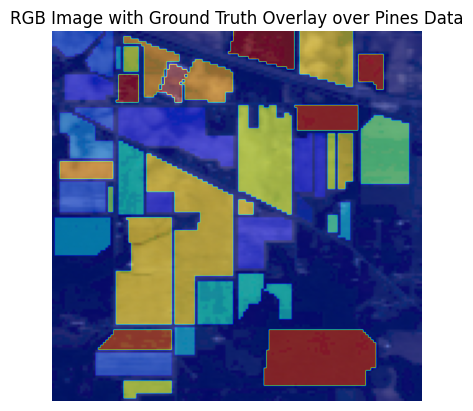

In [2]:
import numpy as np

# Combine the three channels to create an RGB image
rgb_image = np.stack((indian_pines_data[:, :, 28], indian_pines_data[:, :, 18], indian_pines_data[:, :, 8]), axis=-1)

# Normalize the RGB image
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

# Display the RGB image
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')

# Plot ground truth overlay
plt.imshow(gt_pines_data, alpha=0.5, cmap='jet')
plt.title('RGB Image with Ground Truth Overlay over Pines Data')
plt.axis('off')

plt.show()

In [3]:
print(gt_pines_data)

[[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


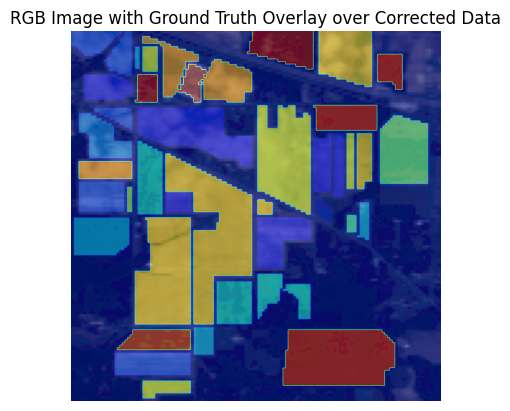

In [4]:
# Combine the three channels to create an RGB image
rgb_image = np.stack((corr_pines_data[:, :, 28], corr_pines_data[:, :, 18], corr_pines_data[:, :, 8]), axis=-1)

# Normalize the RGB image
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

# Display the RGB image
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')

# Plot ground truth overlay
plt.imshow(gt_pines_data, alpha=0.5, cmap='jet')
plt.title('RGB Image with Ground Truth Overlay over Corrected Data')
plt.axis('off')

plt.show()

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define the tile size (e.g., 64x64 pixels)
tile_size = 32

# Get the dimensions of the original image
height, width, num_bands = indian_pines_data.shape

# Calculate the number of tiles in each dimension
num_tiles_height = height // tile_size
num_tiles_width = width // tile_size

# Initialize empty lists for tiles and corresponding ground truth labels
tiles = []
labels = []

# Iterate over each tile
for i in range(num_tiles_height):
    for j in range(num_tiles_width):
        # Calculate the indices for each tile
        start_row = i * tile_size
        end_row = start_row + tile_size
        start_col = j * tile_size
        end_col = start_col + tile_size
        
        # Extract the tile from the original image
        tile = indian_pines_data[start_row:end_row, start_col:end_col, :]
        
        # Extract the corresponding ground truth labels for the tile
        tile_labels = gt_pines_data[start_row:end_row, start_col:end_col]
        
        # Append the tile and labels to the lists
        tiles.append(tile)
        labels.append(tile_labels)

# Convert the lists to numpy arrays
tiles = np.array(tiles)
labels = np.array(labels)

# Split the tiles and labels into training and testing sets
train_tiles, test_tiles, train_labels, test_labels = train_test_split(tiles, labels, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", train_tiles.shape, train_labels.shape)
print("Testing set shape:", test_tiles.shape, test_labels.shape)

Training set shape: (12, 32, 32, 220) (12, 32, 32)
Testing set shape: (4, 32, 32, 220) (4, 32, 32)


In [38]:
print(test_tiles[1].shape)

(32, 32, 220)


In [6]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate the images by 10 degrees
    width_shift_range=0.1,   # Randomly shift the images horizontally by 10% of the total width
    height_shift_range=0.1,  # Randomly shift the images vertically by 10% of the total height
    zoom_range=0.1,          # Randomly zoom the images by 10%
    horizontal_flip=True,    # Randomly flip the images horizontally
    vertical_flip=False,     # Do not flip the images vertically
)

# Reshape the training data to match the expected input shape of the ImageDataGenerator
train_tiles_reshaped = train_tiles.reshape(train_tiles.shape[0], tile_size, tile_size, num_bands)

# Generate augmented samples
augmented_tiles = []
augmented_labels = []
num_augmented_samples = 4  # Number of augmented samples to generate per original sample

for i in range(train_tiles_reshaped.shape[0]):
    original_sample = train_tiles_reshaped[i]
    original_label = train_labels[i]
    
    augmented_samples = datagen.flow(np.expand_dims(original_sample, axis=0), batch_size=num_augmented_samples)
    
    for j in range(num_augmented_samples):
        augmented_sample = augmented_samples.next()[0]
        augmented_tiles.append(augmented_sample)
        augmented_labels.append(original_label)

# Convert the augmented samples and labels to numpy arrays
augmented_tiles = np.array(augmented_tiles)
augmented_labels = np.array(augmented_labels)

# Concatenate the original training samples with the augmented samples
augmented_train_tiles = np.concatenate((train_tiles_reshaped, augmented_tiles), axis=0)
augmented_train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

# Print the shapes of the augmented training data
print("Augmented Training set shape:", augmented_train_tiles.shape, augmented_train_labels.shape)

2023-11-15 15:22:56.888739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/site-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 32, 32, 220) (220 channels).
  warnings.warn(


Augmented Training set shape: (60, 32, 32, 220) (60, 32, 32)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

# Define the U-Net architecture
def unet(input_size, num_classes):
    inputs = Input(input_size)
    
    # Downsample path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Upsample path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    concat6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Set the input shape and number of classes
input_shape = (tile_size, tile_size, num_bands)
num_classes = 17

# Create the U-Net model
model = unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(augmented_train_tiles, augmented_train_labels, batch_size=16, epochs=50, validation_data=(test_tiles, test_labels))

Epoch 1/50
4/4 [==============================] - 12s 2s/step - loss: 1175.4613 - accuracy: 0.0299 - val_loss: 707.4074 - val_accuracy: 0.0356
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 545.8683 - accuracy: 0.0258 - val_loss: 418.9806 - val_accuracy: 0.0828
Epoch 3/50
4/4 [==============================] - 6s 1s/step - loss: 288.1745 - accuracy: 0.1229 - val_loss: 220.9765 - val_accuracy: 0.2815
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 187.9696 - accuracy: 0.3270 - val_loss: 199.9268 - val_accuracy: 0.2004
Epoch 5/50
4/4 [==============================] - 7s 2s/step - loss: 149.8760 - accuracy: 0.3079 - val_loss: 158.1250 - val_accuracy: 0.2925
Epoch 6/50
4/4 [==============================] - 6s 2s/step - loss: 107.3531 - accuracy: 0.3325 - val_loss: 128.1606 - val_accuracy: 0.2476
Epoch 7/50
4/4 [==============================] - 7s 2s/step - loss: 84.5865 - accuracy: 0.3222 - val_loss: 112.2596 - val_accuracy: 0.2876
Epoch 8/50
4

In [16]:
import pickle

# Assuming your model is named 'model'
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
f.close()


In [7]:
import pickle

# Load the saved model
model_path = '../task3/model.pkl'
# with open(model_path, 'rb') as file:
#     loaded_model = pickle.load(file)

try:
    file_input = open(model_path, 'rb')
    loaded_model = pickle.load(file_input)
except EOFError:
    print('An EOFError exception occurred. The file is empty')


In [8]:
num_classes = 17

In [9]:
import numpy as np
import cv2

# Use the trained model to predict segmentation masks for the test tiles
predicted_masks = loaded_model.predict(test_tiles)

# Convert predicted masks to class labels
predicted_labels = np.argmax(predicted_masks, axis=-1)

# Define the color mapping for each class label
color_mapping = {
    0: [255, 0, 0],     # Class 0 is represented by red color
    1: [0, 255, 0],     # Class 1 is represented by green color
    2: [0, 0, 255],     # Class 2 is represented by blue color
    3: [255, 255, 0],   # Class 3 is represented by yellow color
    4: [255, 0, 255],   # Class 4 is represented by magenta color
    5: [0, 255, 255],   # Class 5 is represented by cyan color
    6: [128, 0, 0],     # Class 6 is represented by dark red color
    7: [0, 128, 0],     # Class 7 is represented by dark green color
    8: [0, 0, 128],     # Class 8 is represented by dark blue color
    9: [128, 128, 0],   # Class 9 is represented by dark yellow color
    10: [128, 0, 128],  # Class 10 is represented by dark magenta color
    11: [0, 128, 128],  # Class 11 is represented by dark cyan color
    12: [64, 0, 0],     # Class 12 is represented by deep red color
    13: [0, 64, 0],     # Class 13 is represented by deep green color
    14: [0, 0, 64],     # Class 14 is represented by deep blue color
    15: [64, 64, 0],    # Class 15 is represented by deep yellow color
    16: [128, 128, 128]
}

# Create a blank color image with the same shape as the test tiles
colored_images = np.zeros((test_tiles.shape[0], test_tiles.shape[1], test_tiles.shape[2], 3), dtype=np.uint8)

# Assign colors to each pixel based on the predicted labels
for i in range(len(predicted_labels)):
    for class_label in range(num_classes):
        mask = predicted_labels[i] == class_label
        colored_images[i][mask] = color_mapping[class_label]




1/1 [==============================] - 0s 443ms/step


In [ ]:
# Display the input image and the segmentation results

bands = [29, 19, 9]
images = [tile[:, :, bands] for tile in test_tiles]

# Concatenate the images along the width axis
image = np.concatenate(images, axis=1)

# Create a new image using the desired bands
image = np.transpose(image, (1, 0, 2))  # Transpose the image dimensions
image = np.flipud(image)  # Flip the image vertically

# Display the image
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
print(test_labels.shape)
print("Unique test_labels: ",np.unique(test_labels))
print(predicted_labels.shape)
print("Unique predicted_labels: ",np.unique(predicted_labels))

(4, 32, 32)
Unique test_labels:  [ 0  2  3  5  6 10 11 12 14 15 16]
(4, 32, 32)
Unique predicted_labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


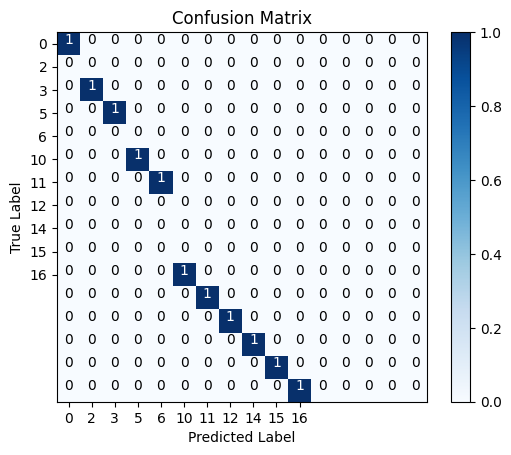

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_labels = np.array([0, 2, 3, 5, 6, 10, 11, 12, 14, 15, 16])
predicted_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

# Remove extra predicted labels
predicted_labels = predicted_labels[:len(true_labels)]


# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = np.unique(true_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill in the matrix with values
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute precision
precision = precision_score(true_labels, predicted_labels, average='micro')

# Compute recall
recall = recall_score(true_labels, predicted_labels, average='micro')

# Compute F-measure
f_measure = f1_score(true_labels, predicted_labels, average='micro')

# Print the metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F-measure: {:.2f}".format(f_measure))

Accuracy: 0.09
Precision: 0.09
Recall: 0.09
F-measure: 0.09
